## LFW - Numpy

First we obtain the packages and data we will need.

In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Let's have a closer look at our data.

In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


We see that the dataset describes 7 people, for each of whom there are 1288/7 = 184 photos each with 1850 pixels. Next we create a train/test split, normalise the data relative to the train set and train a PCA classifier.

In [4]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean
#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))
#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 150)
(322, 150)


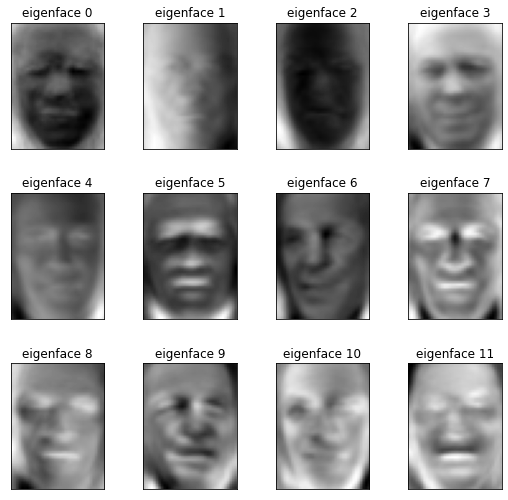

In [7]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

(966,)


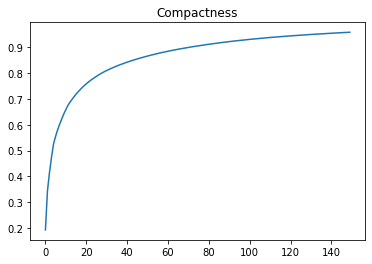

In [6]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)

plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [14]:
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
4
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)

Total Testing 322
Predictions [3 3 1 3 3 3 3 1 3 3 3 6 3 3 3 3 3 3 3 4 1 0 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 3 3 3 3 4 3 3 3 3 3 3 2 1 3 5 3 1 1 3 6 3 4 1 4 3 3 1 6 3 3
 3 3 3 6 1 3 6 3 2 3 3 3 3 3 3 3 3 3 3 3 1 3 3 1 2 6 3 3 3 3 3 3 3 3 3 1 3
 3 6 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 4 3 3 3 3 1 3 3 1 3
 4 1 1 3 3 3 3 3 3 3 3 3 6 5 5 3 3 3 5 1 3 3 1 3 3 1 6 3 3 2 2 3 3 3 3 3 3
 3 3 3 3 2 4 3 2 3 6 3 3 3 3 6 3 3 3 3 5 3 4 2 4 3 1 5 6 3 3 5 3 2 3 3 3 3
 3 1 1 3 3 3 1 3 3 3 3 3 3 1 1 6 3 3 3 4 3 3 4 3 3 3 3 4 4 3 3 4 3 4 3 1 3
 3 3 3 3 1 3 5 1 1 3 1 1 1 3 3 6 3 3 3 3 3 1 1 3 3 3 3 3 5 3 4 3 3 5 3 3 3
 3 3 3 3 3 6 3 2 1 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 4 3]
Which Correct: [ True  True False  True  True  True False  True  True  True  True False
  True False  True  True  True  True  True  True  True False  True False
 False False False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False  True
 False  T

In [15]:
 print(classification_report(y_test, predictions, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.69      0.52      0.59        60
  Donald Rumsfeld       0.60      0.22      0.32        27
    George W Bush       0.61      0.90      0.73       146
Gerhard Schroeder       0.45      0.36      0.40        25
      Hugo Chavez       0.55      0.40      0.46        15
       Tony Blair       0.61      0.31      0.41        36

         accuracy                           0.61       322
        macro avg       0.50      0.39      0.42       322
     weighted avg       0.58      0.61      0.57       322



## LFW - TensorFlow

We perform PCA by taking the SVD of the data matrix; the rows of V are the most informative facial features (eigenvectors-ish), S contains the singular values along the diagonal (eigenvalues-ish) while the columns of U are the compressed faces from the data matrix (projected vectors).

In [8]:
import tensorflow as tf
from tensorflow import keras

In [9]:
U, S, V = tf.linalg.svd(X_train)

components = tf.transpose(V)[:n_components]
eigenfaces = tf.reshape(components, [n_components, h, w])

X_transformed = tf.tensordot(X_train, tf.transpose(components), 1)
X_test_transformed = tf.tensordot(X_test, tf.transpose(components), 1)

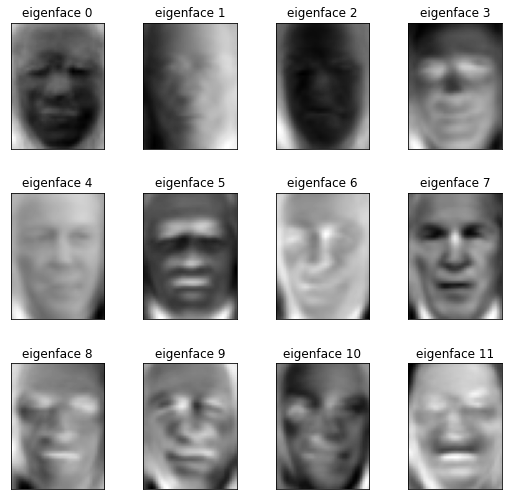

In [10]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """
    Helper function to plot a gallery of eigenportraits.
    
    Args:
        images (tensor): rank-2 tensor of greyscale images, each in a row.
        titles (str): labels for each image.
        h (int): height in pixels of each image.
        w (int): width in pixels of each image.
    """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(tf.reshape(images[i], [h, w]), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

Next we build a NN with a single hidden layer and train it to classify the uncompressed faces. To begin with, we scale the data using ``sklearn``'s ``StandardScaler``.

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

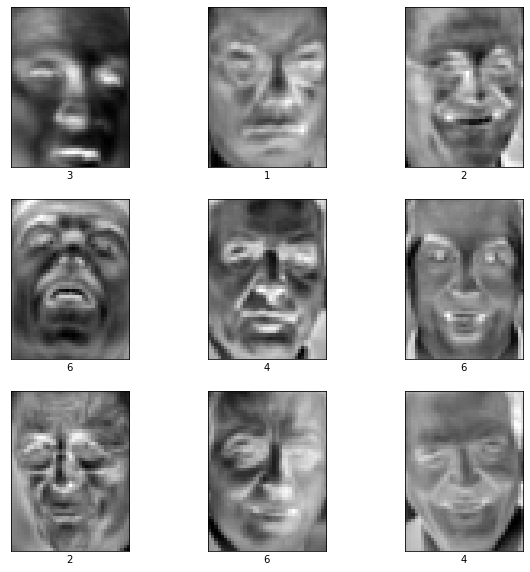

In [16]:
plt.figure(figsize=(10,10))

n_plot = 3

for i in range(n_plot**2):
    plt.subplot(n_plot,n_plot,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.reshape(X_train, [-1, h, w])[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

Now we're ready to set up the layer; let's give it 30 neurons.

In [79]:
model = keras.Sequential([
    keras.Input(shape=(1850)),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

In [80]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 30)                55530     
_________________________________________________________________
dense_23 (Dense)             (None, 7)                 217       
Total params: 55,747
Trainable params: 55,747
Non-trainable params: 0
_________________________________________________________________


And with that we're ready to train.

In [81]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [82]:
model.fit(X_train, y_train, epochs=10)

Train on 966 samples
Epoch 1/10
966/966 [==============================] - 0s 262us/sample - loss: 1.7689 - accuracy: 0.3923
Epoch 2/10
966/966 [==============================] - 0s 53us/sample - loss: 1.5635 - accuracy: 0.6190
Epoch 3/10
966/966 [==============================] - 0s 53us/sample - loss: 1.4807 - accuracy: 0.6936
Epoch 4/10
966/966 [==============================] - 0s 52us/sample - loss: 1.4191 - accuracy: 0.7609
Epoch 5/10
966/966 [==============================] - 0s 52us/sample - loss: 1.3773 - accuracy: 0.8023
Epoch 6/10
966/966 [==============================] - 0s 51us/sample - loss: 1.3316 - accuracy: 0.8458
Epoch 7/10
966/966 [==============================] - 0s 51us/sample - loss: 1.2858 - accuracy: 0.8975
Epoch 8/10
966/966 [==============================] - 0s 51us/sample - loss: 1.2511 - accuracy: 0.9317
Epoch 9/10
966/966 [==============================] - 0s 52us/sample - loss: 1.2366 - accuracy: 0.9420
Epoch 10/10
966/966 [==============================

In [83]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

322/322 - 0s - loss: 1.3513 - accuracy: 0.8354

Test accuracy: 0.83540374


We see that our model has very high variance; let's try with two convolving layers as well as a fully connected layer prior to classification. First we will reshape our data matrix.

In [95]:
model = keras.Sequential([
    keras.Input(shape=(h, w, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.Dense(7, activation='softmax')
])

In [96]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 50, 37, 32)        320       
_________________________________________________________________
dense_28 (Dense)             (None, 50, 37, 7)         231       
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [93]:
X_train_r = tf.reshape(X_train, [-1, h, w])
X_test_r = tf.reshape(X_test, [-1, h, w])

X_train_r = tf.expand_dims(X_train_r, 3)
X_test_r = tf.expand_dims(X_test_r, 3)

In [61]:
X_train_r.shape

TensorShape([966, 50, 37, 1])

In [94]:
model.fit(X_train_r, y_train_r, epochs=10)

Train on 966 samples
Epoch 1/10
 32/966 [..............................] - ETA: 12s

InvalidArgumentError:  Incompatible shapes: [32,1] vs. [32,50,37]
	 [[node metrics/accuracy/Equal (defined at <ipython-input-94-602e63f60813>:1) ]] [Op:__inference_distributed_function_15160]

Function call stack:
distributed_function


In [107]:
tf.reshape(X_train, [-1, h, w]).shape

TensorShape([966, 50, 37])

In [111]:
tf.expand_dims(X_train, 2)

<tf.Tensor: shape=(966, 1850, 1), dtype=float32, numpy=
array([[[ 0.9755568 ],
        [ 1.0886515 ],
        [ 0.9337338 ],
        ...,
        [ 1.5169595 ],
        [ 1.6972578 ],
        [ 1.746823  ]],

       [[ 1.5245591 ],
        [ 0.98559475],
        [ 0.42335454],
        ...,
        [-1.1344373 ],
        [-0.9571415 ],
        [-0.80165356]],

       [[ 0.8186987 ],
        [ 0.757397  ],
        [ 0.6012139 ],
        ...,
        [-1.1515708 ],
        [-1.0502784 ],
        [-0.97350794]],

       ...,

       [[ 1.0539855 ],
        [ 0.77948064],
        [ 0.5857481 ],
        ...,
        [-0.06788187],
        [ 0.05042939],
        [ 0.5606076 ]],

       [[ 0.39090475],
        [ 0.3893364 ],
        [ 1.02653   ],
        ...,
        [-0.86030257],
        [-0.81743634],
        [-0.6381822 ]],

       [[-1.7480661 ],
        [-1.8631943 ],
        [-2.1362736 ],
        ...,
        [ 0.56605464],
        [ 0.86325985],
        [ 1.2857499 ]]], dtype=float32